## A/B Testing Project
You've received an analytical task from an international online store. Your predecessor failed to complete it: they launched an A/B test and then quit (to start a watermelon farm in Brazil). They left only the technical specifications and the test results.

##### Technical description
- Test name: recommender_system_test
- Groups: А (control), B (new payment funnel)
- Launch date: 2020-12-07
- Date when they stopped taking up new users: 2020-12-21
- End date: 2021-01-01
- Audience: 15% of the new users from the EU region
- Purpose of the test: testing changes related to the introduction of an improved recommendation system
- Expected result: within 14 days of signing up, users will show better conversion into product page views (the product_page event), instances of adding items to the shopping cart (product_cart), and purchases (purchase). At each stage of the funnel product_page → product_cart → purchase, there will be at least a 10% increase.
- Expected number of test participants: 6000 

##### Description of the data

##### Structure of ab_project__marketing_events_us.csv:
- name — the name of the marketing event
- regions — regions where the ad campaign will be held
- start_dt — campaign start date
- finish_dt — campaign end date

##### Structure of final_ab_new_users_us.csv:
- user_id
- first_date — sign-up date
- region
- device — device used to sign up

##### Structure of final_ab_events_us.csv:
- user_id
- event_dt — event date and time
- event_name — event type name
- details — additional data on the event (for instance, the order total in USD for purchase events)

##### Structure of final_ab_participants_us.csv:
- user_id
- ab_test — test name
- group — the test group the user belonged to


##### Instructions for completing the task
- Describe the goals of the study.
- Explore the data:
    - Do types need to be converted?
    - Are there any missing or duplicate values? If so, how would you characterize them?
- Carry out exploratory data analysis:
    - Study conversion at different stages of the funnel.
    - Is the number of events per user distributed equally among the samples?
    - Are there users who are present in both samples?
    - How is the number of events distributed among days?
    - Think of the possible details in the data that you have to take into account before starting the A/B test?
- Evaluate the A/B test results:
    - What can you tell about the A/B test results?
    - Use a z-test to check the statistical difference between the proportions.
- Describe your conclusions regarding the EDA stage and the A/B test results.

#### Step 1. Data Pre Processing

In [1]:
#data preprocessing and upload
#import libraries
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math as mth
from scipy import stats as st

In [2]:
ab_marketing = pd.read_csv('ab_project_marketing_events_us.csv', sep=',', dtype={'device': 'category'}, parse_dates=['start_dt', 'finish_dt'])
ab_newusers = pd.read_csv('final_ab_new_users_us (1).csv', sep=',', parse_dates=['first_date'])
ab_events = pd.read_csv('final_ab_events_us (1).csv', sep=',', parse_dates=['event_dt'])
ab_participants = pd.read_csv('final_ab_participants_us (1).csv', sep=',')

display(ab_marketing)
display(ab_newusers)
display(ab_events)
display(ab_participants)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test


In [3]:
#study the data they contain make sure the data types are correct
ab_marketing.info()
ab_newusers.info()
ab_events.info()
ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total

In [4]:
#checking for null values in each dataset
ab_marketing.isnull().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [5]:
ab_newusers.isnull().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [6]:
ab_events.isnull().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

In [7]:
ab_events['details'].fillna(0, inplace = True)

In [8]:
ab_events.describe()

,details
count,440317.000000
mean,3.402282
std,28.495956
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,499.990000


In [9]:
ab_participants.isnull().sum()

user_id    0
group      0
ab_test    0
dtype: int64

In [10]:
#checking for duplicates
ab_marketing.duplicated().sum()

0

In [11]:
ab_newusers.duplicated().sum()

0

In [12]:
ab_events.duplicated().sum()

0

In [13]:
ab_participants.duplicated().sum()

0

#### Conclusion

no duplicates listed, null events in details are because of information not being complete in the study. removing this information would skew the data so I left it and converted it to 0. converted date values to date time appropriately.

#### Step 2. Exploratory Data Analysis
    - Study conversion at different stages of the funnel.
    - Is the number of events per user distributed equally among the samples?
    - Are there users who are present in both samples?
    - How is the number of events distributed among days?
    - Think of the possible details in the data that you have to take into account before starting the A/B test?

In [14]:
#number of people who use it daily, weekly, monthly and yearly
ab_events['session_date'] = ab_events['event_dt'].dt.date
ab_events['session_year']  = ab_events['event_dt'].dt.year
ab_events['session_month'] = ab_events['event_dt'].dt.month
ab_events['session_week']  = ab_events['event_dt'].dt.week
ab_events['start_day'] = ab_events['event_dt'].dt.day
display(ab_events)

,user_id,event_dt,event_name,details,session_date,session_year,session_month,session_week,start_day
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07,2020,12,50,7
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,2020,12,50,7
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07,2020,12,50,7
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,2020,12,50,7
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07,2020,12,50,7
...,...,...,...,...,...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,0.00,2020-12-30,2020,12,53,30
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,0.00,2020-12-30,2020,12,53,30
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,0.00,2020-12-30,2020,12,53,30
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,0.00,2020-12-30,2020,12,53,30


In [15]:
dau_total = ab_events.groupby('session_date').agg({'user_id': 'nunique'}).mean()
wau_total = ab_events.groupby(['session_year', 'session_week']).agg({'user_id': 'nunique'}).mean()
mau_total = ab_events.groupby(['session_year', 'session_month']).agg({'user_id': 'nunique'}).mean()

print('Users per Day', int(dau_total))
print('Users per Week', int(wau_total))
print('Users per Month',int(mau_total))

Users per Day 7904
Users per Week 26892
Users per Month 58703


In [16]:
daily_sessions_total = ab_events.groupby('session_date').agg({'user_id':'count'}).mean()
print('Average sessions daily:', int(daily_sessions_total))

Average sessions daily: 18346


In [17]:
#merging events and new users
eventandnew = ab_events.merge(ab_newusers, on='user_id', how = 'left')
display(eventandnew)


,user_id,event_dt,event_name,details,session_date,session_year,session_month,session_week,start_day,first_date,region,device
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07,2020,12,50,7,2020-12-07,N.America,iPhone
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,2020,12,50,7,2020-12-07,EU,iPhone
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07,2020,12,50,7,2020-12-07,N.America,iPhone
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,2020,12,50,7,2020-12-07,EU,iPhone
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07,2020,12,50,7,2020-12-07,EU,Android
...,...,...,...,...,...,...,...,...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,0.00,2020-12-30,2020,12,53,30,2020-12-07,EU,Android
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,0.00,2020-12-30,2020,12,53,30,2020-12-07,EU,PC
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,0.00,2020-12-30,2020,12,53,30,2020-12-07,EU,Android
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,0.00,2020-12-30,2020,12,53,30,2020-12-07,EU,iPhone


In [18]:
#merging new users and AB tests
eventparticipants = ab_participants.merge(eventandnew, on='user_id', how = 'left')
display(eventparticipants)

,user_id,group,ab_test,event_dt,event_name,details,session_date,session_year,session_month,session_week,start_day,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,2020.0,12.0,50.0,7.0,2020-12-07,EU,PC
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99,2020-12-25,2020.0,12.0,52.0,25.0,2020-12-07,EU,PC
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,0.00,2020-12-07,2020.0,12.0,50.0,7.0,2020-12-07,EU,PC
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:57,product_cart,0.00,2020-12-25,2020.0,12.0,52.0,25.0,2020-12-07,EU,PC
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,0.00,2020-12-07,2020.0,12.0,50.0,7.0,2020-12-07,EU,PC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110363,63FBE257B05F2245,A,interface_eu_test,2020-12-23 13:03:17,login,0.00,2020-12-23,2020.0,12.0,52.0,23.0,2020-12-20,EU,Android
110364,79F9ABFB029CF724,B,interface_eu_test,2020-12-14 19:12:49,login,0.00,2020-12-14,2020.0,12.0,51.0,14.0,2020-12-14,EU,PC
110365,79F9ABFB029CF724,B,interface_eu_test,2020-12-15 01:50:22,login,0.00,2020-12-15,2020.0,12.0,51.0,15.0,2020-12-14,EU,PC
110366,79F9ABFB029CF724,B,interface_eu_test,2020-12-16 19:27:36,login,0.00,2020-12-16,2020.0,12.0,51.0,16.0,2020-12-14,EU,PC


In [19]:
reccomenderdata= eventparticipants.query('ab_test == "recommender_system_test"')

In [20]:
dau_total = reccomenderdata.groupby('session_date').agg({'user_id': 'nunique'}).mean()
print('Average Daily Usage:', int(dau_total))

Average Daily Usage: 466


In [21]:
#date column
reccomenderdata['date'] = reccomenderdata['event_dt'].dt.date
reccomenderdata
#time column
reccomenderdata['time'] = reccomenderdata['event_dt'].dt.time
eventandnew

<ipython-input-21-a70e39fb56ca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reccomenderdata['date'] = reccomenderdata['event_dt'].dt.date
<ipython-input-21-a70e39fb56ca>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reccomenderdata['time'] = reccomenderdata['event_dt'].dt.time


,user_id,event_dt,event_name,details,session_date,session_year,session_month,session_week,start_day,first_date,region,device
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07,2020,12,50,7,2020-12-07,N.America,iPhone
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,2020,12,50,7,2020-12-07,EU,iPhone
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07,2020,12,50,7,2020-12-07,N.America,iPhone
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,2020,12,50,7,2020-12-07,EU,iPhone
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07,2020,12,50,7,2020-12-07,EU,Android
...,...,...,...,...,...,...,...,...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,0.00,2020-12-30,2020,12,53,30,2020-12-07,EU,Android
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,0.00,2020-12-30,2020,12,53,30,2020-12-07,EU,PC
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,0.00,2020-12-30,2020,12,53,30,2020-12-07,EU,Android
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,0.00,2020-12-30,2020,12,53,30,2020-12-07,EU,iPhone


In [22]:
users = reccomenderdata.pivot_table(
    index='user_id', 
    columns='event_name', 
    values='time',
    aggfunc='min')
users.head()

event_name,login,product_cart,product_page,purchase
user_id,,,,
001064FEAAB631A1,03:19:15,NaN,03:19:17,NaN
0010A1C096941592,04:34:37,NaN,04:34:38,04:34:37
00341D8401F0F665,11:14:50,NaN,NaN,NaN
003DF44D7589BBD4,00:54:43,00:54:43,00:54:44,NaN
00505E15A9D81546,05:35:34,NaN,NaN,NaN


In [23]:
#conversion at different stages of the funnel
ExpIdbyDate = reccomenderdata.pivot_table(index='event_name', values='user_id',aggfunc='nunique')
ExpIdbyDate.sort_values(by='user_id',ascending=False)

,event_name,user_id
event_name,,
login,1,3675
product_page,1,2303
purchase,1,1128
product_cart,1,1079


In [24]:
users = reccomenderdata.pivot_table(
    index='user_id', 
    columns='event_name', 
    values='time',
    aggfunc='min')
users.head()

event_name,login,product_cart,product_page,purchase
user_id,,,,
001064FEAAB631A1,03:19:15,NaN,03:19:17,NaN
0010A1C096941592,04:34:37,NaN,04:34:38,04:34:37
00341D8401F0F665,11:14:50,NaN,NaN,NaN
003DF44D7589BBD4,00:54:43,00:54:43,00:54:44,NaN
00505E15A9D81546,05:35:34,NaN,NaN,NaN


In [25]:
#Study conversion at different stages of the funnel
step_1 = ~users['login'].isna()
step_2 = step_1 & (users['product_page'] > users['login'])
step_3 = step_2 & (users['product_cart'] > users['product_page'])
step_4 = step_3 & (users['purchase'] > users['product_cart'])

n_login = users[step_1].shape[0]
n_productpage = users[step_2].shape[0]
n_cart = users[step_3].shape[0]
n_payment = users[step_4].shape[0]

n_pageview_conv = (n_login/(n_login+n_productpage+n_cart+n_payment))
n_productpage_conv = (n_productpage/(n_login+n_productpage+n_cart+n_payment))
n_cart_conv = (n_cart/(n_login+n_productpage+n_cart+n_payment))
n_payment_conv = (n_payment/(n_login+n_productpage+n_cart+n_payment))

print('Login:', n_login, 'Conv%', n_pageview_conv)
print('Viewed Product:', n_productpage, 'Conv%', n_productpage_conv)
print('Had products in Cart:', n_cart,'Conv%', n_cart_conv)
print('Paid:', n_payment, 'Conv%', n_payment_conv)



Login: 3675 Conv% 0.7262845849802372
Viewed Product: 1294 Conv% 0.2557312252964427
Had products in Cart: 91 Conv% 0.01798418972332016
Paid: 0 Conv% 0.0


#### Conclusion
- Order actions that take place are login, product page, product cart and purchase. 

- As we investigate the funnel of users from the reccomender test we see that users who ended up taking steps closer to a purchase that inevitably resulted in no purchases. The users who logged in into the main screen were 3675  (72% of the users) Then the users that viewed products were 1294 (25% of the users), then 91  users added products to the cart (1% of the users), then we ended up getting no users from the test group who actually made a purchase. The promotions ended up resulting in a retention of less than 1%

In [26]:

display(eventparticipants)

,user_id,group,ab_test,event_dt,event_name,details,session_date,session_year,session_month,session_week,start_day,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,2020.0,12.0,50.0,7.0,2020-12-07,EU,PC
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99,2020-12-25,2020.0,12.0,52.0,25.0,2020-12-07,EU,PC
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,0.00,2020-12-07,2020.0,12.0,50.0,7.0,2020-12-07,EU,PC
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:57,product_cart,0.00,2020-12-25,2020.0,12.0,52.0,25.0,2020-12-07,EU,PC
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,0.00,2020-12-07,2020.0,12.0,50.0,7.0,2020-12-07,EU,PC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110363,63FBE257B05F2245,A,interface_eu_test,2020-12-23 13:03:17,login,0.00,2020-12-23,2020.0,12.0,52.0,23.0,2020-12-20,EU,Android
110364,79F9ABFB029CF724,B,interface_eu_test,2020-12-14 19:12:49,login,0.00,2020-12-14,2020.0,12.0,51.0,14.0,2020-12-14,EU,PC
110365,79F9ABFB029CF724,B,interface_eu_test,2020-12-15 01:50:22,login,0.00,2020-12-15,2020.0,12.0,51.0,15.0,2020-12-14,EU,PC
110366,79F9ABFB029CF724,B,interface_eu_test,2020-12-16 19:27:36,login,0.00,2020-12-16,2020.0,12.0,51.0,16.0,2020-12-14,EU,PC


In [27]:
# Is the number of events per user distributed equally among the samples?
users_average= eventparticipants.groupby(['user_id']).agg({'event_name':'nunique'}).sum()
print('Average Users in logs:', int(users_average))

Average Users in logs: 31517


In [28]:
#average number of events per user
users_per_event = eventparticipants.groupby(['user_id']).agg({'event_name':'count'})
users_per_event.sort_values(by='event_name', ascending=False).head(20)

,event_name
user_id,
97AD409895906A32,40
84DC74ED5E60BA6A,40
C165E8C0C5DE19FF,40
0082295A41A867B5,40
A2DB18F90D9E3362,40
2B8FD20CA8A2A616,40
6B1D0D8C4F8FBBEC,40
18569C8DCB0771B6,40
9A5549A4A85FCF06,38


In [29]:
TotalEvents_PerUser = eventparticipants.groupby('user_id').agg({'event_name':'count'}).mean()
TotalEvents_PerUser

event_name    6.397756
dtype: float64

In [30]:
print('Average events per user in logs:', TotalEvents_PerUser)

Average events per user in logs: event_name    6.397756
dtype: float64


In [31]:
#what period of time does the data cover?
eventparticipants['duration_start'] = eventparticipants['event_dt'].min()
eventparticipants['duration_end'] = eventparticipants['event_dt'].max()
display(eventparticipants)

,user_id,group,ab_test,event_dt,event_name,details,session_date,session_year,session_month,session_week,start_day,first_date,region,device,duration_start,duration_end
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,2020.0,12.0,50.0,7.0,2020-12-07,EU,PC,2020-12-07 00:02:48,2020-12-30 18:28:55
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99,2020-12-25,2020.0,12.0,52.0,25.0,2020-12-07,EU,PC,2020-12-07 00:02:48,2020-12-30 18:28:55
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,0.00,2020-12-07,2020.0,12.0,50.0,7.0,2020-12-07,EU,PC,2020-12-07 00:02:48,2020-12-30 18:28:55
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:57,product_cart,0.00,2020-12-25,2020.0,12.0,52.0,25.0,2020-12-07,EU,PC,2020-12-07 00:02:48,2020-12-30 18:28:55
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,0.00,2020-12-07,2020.0,12.0,50.0,7.0,2020-12-07,EU,PC,2020-12-07 00:02:48,2020-12-30 18:28:55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110363,63FBE257B05F2245,A,interface_eu_test,2020-12-23 13:03:17,login,0.00,2020-12-23,2020.0,12.0,52.0,23.0,2020-12-20,EU,Android,2020-12-07 00:02:48,2020-12-30 18:28:55
110364,79F9ABFB029CF724,B,interface_eu_test,2020-12-14 19:12:49,login,0.00,2020-12-14,2020.0,12.0,51.0,14.0,2020-12-14,EU,PC,2020-12-07 00:02:48,2020-12-30 18:28:55
110365,79F9ABFB029CF724,B,interface_eu_test,2020-12-15 01:50:22,login,0.00,2020-12-15,2020.0,12.0,51.0,15.0,2020-12-14,EU,PC,2020-12-07 00:02:48,2020-12-30 18:28:55
110366,79F9ABFB029CF724,B,interface_eu_test,2020-12-16 19:27:36,login,0.00,2020-12-16,2020.0,12.0,51.0,16.0,2020-12-14,EU,PC,2020-12-07 00:02:48,2020-12-30 18:28:55


In [32]:
eventparticipants['session_duration'] = (eventparticipants['duration_end'] - eventparticipants['duration_start'])
eventparticipants

,user_id,group,ab_test,event_dt,event_name,details,session_date,session_year,session_month,session_week,start_day,first_date,region,device,duration_start,duration_end,session_duration
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,2020.0,12.0,50.0,7.0,2020-12-07,EU,PC,2020-12-07 00:02:48,2020-12-30 18:28:55,23 days 18:26:07
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99,2020-12-25,2020.0,12.0,52.0,25.0,2020-12-07,EU,PC,2020-12-07 00:02:48,2020-12-30 18:28:55,23 days 18:26:07
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,0.00,2020-12-07,2020.0,12.0,50.0,7.0,2020-12-07,EU,PC,2020-12-07 00:02:48,2020-12-30 18:28:55,23 days 18:26:07
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:57,product_cart,0.00,2020-12-25,2020.0,12.0,52.0,25.0,2020-12-07,EU,PC,2020-12-07 00:02:48,2020-12-30 18:28:55,23 days 18:26:07
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,0.00,2020-12-07,2020.0,12.0,50.0,7.0,2020-12-07,EU,PC,2020-12-07 00:02:48,2020-12-30 18:28:55,23 days 18:26:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110363,63FBE257B05F2245,A,interface_eu_test,2020-12-23 13:03:17,login,0.00,2020-12-23,2020.0,12.0,52.0,23.0,2020-12-20,EU,Android,2020-12-07 00:02:48,2020-12-30 18:28:55,23 days 18:26:07
110364,79F9ABFB029CF724,B,interface_eu_test,2020-12-14 19:12:49,login,0.00,2020-12-14,2020.0,12.0,51.0,14.0,2020-12-14,EU,PC,2020-12-07 00:02:48,2020-12-30 18:28:55,23 days 18:26:07
110365,79F9ABFB029CF724,B,interface_eu_test,2020-12-15 01:50:22,login,0.00,2020-12-15,2020.0,12.0,51.0,15.0,2020-12-14,EU,PC,2020-12-07 00:02:48,2020-12-30 18:28:55,23 days 18:26:07
110366,79F9ABFB029CF724,B,interface_eu_test,2020-12-16 19:27:36,login,0.00,2020-12-16,2020.0,12.0,51.0,16.0,2020-12-14,EU,PC,2020-12-07 00:02:48,2020-12-30 18:28:55,23 days 18:26:07


In [33]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

print("Average Session Length is:", eventparticipants['session_duration'].mean()) 
print(eventparticipants['session_duration'].value_counts(normalize=True).head(10))

Average Session Length is: 23 days 18:26:06.999996
23 days 18:26:07    1.0
Name: session_duration, dtype: float64


In [34]:
# Are there users who are present in both samples?
eventusercount = eventparticipants.pivot_table(index='ab_test', values='user_id', aggfunc='count' )
eventusercount

,user_id
ab_test,
interface_eu_test,82644
recommender_system_test,27724


In [35]:
uniqueusers= eventparticipants.groupby(['ab_test']).agg({'user_id':'nunique'}).sum()
print('Unique Users in logs:', int(uniqueusers))

Unique Users in logs: 18268


In [36]:
#average number of events per user
users_per_event = eventparticipants.groupby(['user_id']).agg({'ab_test':'count'})
users_per_event.sort_values(by='ab_test', ascending=False).head(20)

,ab_test
user_id,
97AD409895906A32,40
84DC74ED5E60BA6A,40
C165E8C0C5DE19FF,40
0082295A41A867B5,40
A2DB18F90D9E3362,40
2B8FD20CA8A2A616,40
6B1D0D8C4F8FBBEC,40
18569C8DCB0771B6,40
9A5549A4A85FCF06,38


In [37]:
# How is the number of events distributed among days?
users_per_event = eventparticipants.groupby(['event_name']).agg({'session_date':'count'})
users_per_event.sort_values(by='event_name', ascending=False).head(20)

,session_date
event_name,
purchase,15416
product_page,30025
product_cart,14849
login,46335


#### conclusion
When we look at the breakdown of the events by days we see that the login action is at the top followed by product page, followed by purchase, followed by product cart

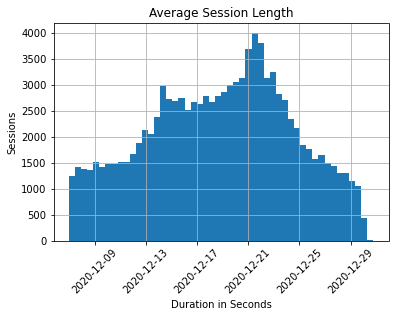

In [38]:
#distribution by time
eventparticipants['event_dt'].hist(bins=50)
plt.xticks(rotation=45)
plt.title("Average Session Length")
plt.ylabel("Sessions")
plt.xlabel("Duration in Seconds")
plt.show()


#### Think of the possible details in the data that you have to take into account before starting the A/B test?


#### Step 3. A/B Test Analysis 
- What can you tell about the A/B test results?
- Use a z-test to check the statistical difference between the proportions.

In [39]:
#users by event name
reccomenderdata.sort_values(by='user_id',ascending=False)

,user_id,group,ab_test,event_dt,event_name,details,session_date,session_year,session_month,session_week,start_day,first_date,region,device,date,time
14333,FFF28D02B1EACBE1,B,recommender_system_test,2020-12-21 15:20:08,login,0.0,2020-12-21,2020.0,12.0,52.0,21.0,2020-12-16,EU,PC,2020-12-21,15:20:08
14326,FFF28D02B1EACBE1,B,recommender_system_test,2020-12-16 08:24:57,product_cart,0.0,2020-12-16,2020.0,12.0,51.0,16.0,2020-12-16,EU,PC,2020-12-16,08:24:57
14329,FFF28D02B1EACBE1,B,recommender_system_test,2020-12-16 08:24:57,product_page,0.0,2020-12-16,2020.0,12.0,51.0,16.0,2020-12-16,EU,PC,2020-12-16,08:24:57
14330,FFF28D02B1EACBE1,B,recommender_system_test,2020-12-21 15:20:10,product_page,0.0,2020-12-21,2020.0,12.0,52.0,21.0,2020-12-16,EU,PC,2020-12-21,15:20:10
14327,FFF28D02B1EACBE1,B,recommender_system_test,2020-12-21 15:20:10,product_cart,0.0,2020-12-21,2020.0,12.0,52.0,21.0,2020-12-16,EU,PC,2020-12-21,15:20:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,001064FEAAB631A1,B,recommender_system_test,2020-12-26 15:55:18,product_page,0.0,2020-12-26,2020.0,12.0,52.0,26.0,2020-12-20,EU,Android,2020-12-26,15:55:18
889,001064FEAAB631A1,B,recommender_system_test,2020-12-20 14:43:27,login,0.0,2020-12-20,2020.0,12.0,51.0,20.0,2020-12-20,EU,Android,2020-12-20,14:43:27
890,001064FEAAB631A1,B,recommender_system_test,2020-12-21 03:19:15,login,0.0,2020-12-21,2020.0,12.0,52.0,21.0,2020-12-20,EU,Android,2020-12-21,03:19:15
891,001064FEAAB631A1,B,recommender_system_test,2020-12-26 15:55:17,login,0.0,2020-12-26,2020.0,12.0,52.0,26.0,2020-12-20,EU,Android,2020-12-26,15:55:17


In [40]:
# event names
def data_by_event_name(event_name):
    """
    Labels users by number of days until first order.
    """
    if event_name == 'login':
        return 'Logged_In'
    if event_name == 'product_cart':
        return 'Cart'
    if event_name == 'product_page':
        return 'Looked at Product'
    else:
        return 'Purchase'


reccomenderdata['days_to_order_group'] = reccomenderdata['event_name'].apply(data_by_event_name)

event_data_pivot = reccomenderdata.pivot_table(index=['event_name', 'group'], columns='days_to_order_group', values='user_id', aggfunc='nunique', fill_value=0)
display(event_data_pivot)

days_to_order_group  Cart  Logged_In  Looked at Product  Purchase
event_name   group                                               
login        A          0       2747                  0         0
             B          0        928                  0         0
product_cart A        824          0                  0         0
             B        255          0                  0         0
product_page A          0          0               1780         0
             B          0          0                523         0
purchase     A          0          0                  0       872
             B          0          0                  0       256

In [41]:
#number of users who performed event name #login
userswhoperformedloginscreen =  reccomenderdata.query('event_name == "login"')
userswhoperformedloginscreen 

,user_id,group,ab_test,event_dt,event_name,details,session_date,session_year,session_month,session_week,start_day,first_date,region,device,date,time,days_to_order_group
6,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,login,0.0,2020-12-07,2020.0,12.0,50.0,7.0,2020-12-07,EU,PC,2020-12-07,14:43:27,Logged_In
7,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:56,login,0.0,2020-12-25,2020.0,12.0,52.0,25.0,2020-12-07,EU,PC,2020-12-25,00:04:56,Logged_In
11,A7A3664BD6242119,A,recommender_system_test,2020-12-20 15:46:02,login,0.0,2020-12-20,2020.0,12.0,51.0,20.0,2020-12-20,EU,iPhone,2020-12-20,15:46:02,Logged_In
12,A7A3664BD6242119,A,recommender_system_test,2020-12-21 00:40:58,login,0.0,2020-12-21,2020.0,12.0,52.0,21.0,2020-12-20,EU,iPhone,2020-12-21,00:40:58,Logged_In
13,A7A3664BD6242119,A,recommender_system_test,2020-12-25 05:19:45,login,0.0,2020-12-25,2020.0,12.0,52.0,25.0,2020-12-20,EU,iPhone,2020-12-25,05:19:45,Logged_In
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27719,6715343AFBA285AE,B,recommender_system_test,2020-12-07 10:12:15,login,0.0,2020-12-07,2020.0,12.0,50.0,7.0,2020-12-07,CIS,Android,2020-12-07,10:12:15,Logged_In
27720,6715343AFBA285AE,B,recommender_system_test,2020-12-08 22:51:16,login,0.0,2020-12-08,2020.0,12.0,50.0,8.0,2020-12-07,CIS,Android,2020-12-08,22:51:16,Logged_In
27721,6715343AFBA285AE,B,recommender_system_test,2020-12-09 02:28:03,login,0.0,2020-12-09,2020.0,12.0,50.0,9.0,2020-12-07,CIS,Android,2020-12-09,02:28:03,Logged_In
27722,6715343AFBA285AE,B,recommender_system_test,2020-12-10 22:55:14,login,0.0,2020-12-10,2020.0,12.0,50.0,10.0,2020-12-07,CIS,Android,2020-12-10,22:55:14,Logged_In


In [42]:
userswhoperformedloginscreen.pivot_table(index='ab_test',values='user_id',aggfunc='count').sort_values(by='user_id', ascending=True).reset_index()

,ab_test,user_id
0,recommender_system_test,11190


##### Conclusion
Users who performed the "login" action between the tests were 11190 in the reccomender system test group out of 27724 total tested and (40%) 

In [43]:
#number of users who performed event name #product
userswhoperformedproductscreen =  reccomenderdata.query('event_name == "product_page"')
userswhoperformedproductscreen 

,user_id,group,ab_test,event_dt,event_name,details,session_date,session_year,session_month,session_week,start_day,first_date,region,device,date,time,days_to_order_group
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,0.0,2020-12-07,2020.0,12.0,50.0,7.0,2020-12-07,EU,PC,2020-12-07,14:43:27,Looked at Product
5,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:57,product_page,0.0,2020-12-25,2020.0,12.0,52.0,25.0,2020-12-07,EU,PC,2020-12-25,00:04:57,Looked at Product
8,A7A3664BD6242119,A,recommender_system_test,2020-12-20 15:46:06,product_page,0.0,2020-12-20,2020.0,12.0,51.0,20.0,2020-12-20,EU,iPhone,2020-12-20,15:46:06,Looked at Product
9,A7A3664BD6242119,A,recommender_system_test,2020-12-21 00:40:59,product_page,0.0,2020-12-21,2020.0,12.0,52.0,21.0,2020-12-20,EU,iPhone,2020-12-21,00:40:59,Looked at Product
10,A7A3664BD6242119,A,recommender_system_test,2020-12-25 05:19:45,product_page,0.0,2020-12-25,2020.0,12.0,52.0,25.0,2020-12-20,EU,iPhone,2020-12-25,05:19:45,Looked at Product
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27714,6715343AFBA285AE,B,recommender_system_test,2020-12-07 10:12:16,product_page,0.0,2020-12-07,2020.0,12.0,50.0,7.0,2020-12-07,CIS,Android,2020-12-07,10:12:16,Looked at Product
27715,6715343AFBA285AE,B,recommender_system_test,2020-12-08 22:51:16,product_page,0.0,2020-12-08,2020.0,12.0,50.0,8.0,2020-12-07,CIS,Android,2020-12-08,22:51:16,Looked at Product
27716,6715343AFBA285AE,B,recommender_system_test,2020-12-09 02:28:04,product_page,0.0,2020-12-09,2020.0,12.0,50.0,9.0,2020-12-07,CIS,Android,2020-12-09,02:28:04,Looked at Product
27717,6715343AFBA285AE,B,recommender_system_test,2020-12-10 22:55:14,product_page,0.0,2020-12-10,2020.0,12.0,50.0,10.0,2020-12-07,CIS,Android,2020-12-10,22:55:14,Looked at Product


In [44]:
userswhoperformedproductscreen.pivot_table(index='ab_test',values='user_id',aggfunc='count').sort_values(by='user_id', ascending=True).reset_index()

,ab_test,user_id
0,recommender_system_test,6930


##### Conclusion
Users who performed the "Product screen" action between the tests were 6930 in the reccomender system test out of 27724 total tested (25%) 

In [45]:
#number of users who performed event name #product cart
userswhoperformedcartscreen =  reccomenderdata.query('event_name == "product_cart"')
userswhoperformedcartscreen 

,user_id,group,ab_test,event_dt,event_name,details,session_date,session_year,session_month,session_week,start_day,first_date,region,device,date,time,days_to_order_group
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,0.0,2020-12-07,2020.0,12.0,50.0,7.0,2020-12-07,EU,PC,2020-12-07,14:43:29,Cart
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:57,product_cart,0.0,2020-12-25,2020.0,12.0,52.0,25.0,2020-12-07,EU,PC,2020-12-25,00:04:57,Cart
36,4FF2998A348C484F,A,recommender_system_test,2020-12-20 19:06:22,product_cart,0.0,2020-12-20,2020.0,12.0,51.0,20.0,2020-12-20,EU,Mac,2020-12-20,19:06:22,Cart
37,4FF2998A348C484F,A,recommender_system_test,2020-12-26 14:39:50,product_cart,0.0,2020-12-26,2020.0,12.0,52.0,26.0,2020-12-20,EU,Mac,2020-12-26,14:39:50,Cart
38,4FF2998A348C484F,A,recommender_system_test,2020-12-28 20:00:24,product_cart,0.0,2020-12-28,2020.0,12.0,53.0,28.0,2020-12-20,EU,Mac,2020-12-28,20:00:24,Cart
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27709,6715343AFBA285AE,B,recommender_system_test,2020-12-07 10:12:15,product_cart,0.0,2020-12-07,2020.0,12.0,50.0,7.0,2020-12-07,CIS,Android,2020-12-07,10:12:15,Cart
27710,6715343AFBA285AE,B,recommender_system_test,2020-12-08 22:51:16,product_cart,0.0,2020-12-08,2020.0,12.0,50.0,8.0,2020-12-07,CIS,Android,2020-12-08,22:51:16,Cart
27711,6715343AFBA285AE,B,recommender_system_test,2020-12-09 02:28:05,product_cart,0.0,2020-12-09,2020.0,12.0,50.0,9.0,2020-12-07,CIS,Android,2020-12-09,02:28:05,Cart
27712,6715343AFBA285AE,B,recommender_system_test,2020-12-10 22:55:14,product_cart,0.0,2020-12-10,2020.0,12.0,50.0,10.0,2020-12-07,CIS,Android,2020-12-10,22:55:14,Cart


In [46]:
userswhoperformedcartscreen.pivot_table(index='ab_test',values='user_id',aggfunc='count').sort_values(by='user_id', ascending=True).reset_index()

,ab_test,user_id
0,recommender_system_test,3247


##### Conclusion
Users who performed the "Cart screen" action between the tests were 3247 in the reccomender system test group out of 27724 total tested(12%)

In [47]:
#number of users who performed event name #checkout
userswhoperformedpurchasescreen =  reccomenderdata.query('event_name == "purchase"')
userswhoperformedpurchasescreen 

,user_id,group,ab_test,event_dt,event_name,details,session_date,session_year,session_month,session_week,start_day,first_date,region,device,date,time,days_to_order_group
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,2020.0,12.0,50.0,7.0,2020-12-07,EU,PC,2020-12-07,14:43:27,Purchase
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99,2020-12-25,2020.0,12.0,52.0,25.0,2020-12-07,EU,PC,2020-12-25,00:04:56,Purchase
17,04988C5DF189632E,A,recommender_system_test,2020-12-14 18:51:34,purchase,4.99,2020-12-14,2020.0,12.0,51.0,14.0,2020-12-14,EU,iPhone,2020-12-14,18:51:34,Purchase
18,04988C5DF189632E,A,recommender_system_test,2020-12-15 02:39:20,purchase,4.99,2020-12-15,2020.0,12.0,51.0,15.0,2020-12-14,EU,iPhone,2020-12-15,02:39:20,Purchase
19,04988C5DF189632E,A,recommender_system_test,2020-12-18 04:33:43,purchase,9.99,2020-12-18,2020.0,12.0,51.0,18.0,2020-12-14,EU,iPhone,2020-12-18,04:33:43,Purchase
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27644,15E18335C5DB30C9,A,recommender_system_test,2020-12-21 21:22:10,purchase,4.99,2020-12-21,2020.0,12.0,52.0,21.0,2020-12-15,N.America,iPhone,2020-12-21,21:22:10,Purchase
27687,053FB26D6D49EDDC,A,recommender_system_test,2020-12-10 04:03:07,purchase,9.99,2020-12-10,2020.0,12.0,50.0,10.0,2020-12-10,N.America,Android,2020-12-10,04:03:07,Purchase
27688,053FB26D6D49EDDC,A,recommender_system_test,2020-12-11 14:11:37,purchase,4.99,2020-12-11,2020.0,12.0,50.0,11.0,2020-12-10,N.America,Android,2020-12-11,14:11:37,Purchase
27689,053FB26D6D49EDDC,A,recommender_system_test,2020-12-25 00:27:11,purchase,4.99,2020-12-25,2020.0,12.0,52.0,25.0,2020-12-10,N.America,Android,2020-12-25,00:27:11,Purchase


In [48]:
userswhoperformedpurchasescreen.pivot_table(index='ab_test',values='user_id',aggfunc='count').sort_values(by='user_id', ascending=True).reset_index()

,ab_test,user_id
0,recommender_system_test,3331


##### Conclusion
Users who performed the "Product screen" action between the tests were 3331 in the reccomender system test group out of 27724 (12%) total tested 

In [49]:
#what is the most popular event among reccomender system test
pop_event = reccomenderdata.drop(['date'], axis=1).groupby('event_name', as_index=False).agg({'group' : 'count'})
display(pop_event)

,event_name,group
0,login,11190
1,product_cart,3247
2,product_page,6930
3,purchase,3331


#### Conclusion
Login is the most popular event

In [50]:
userswhoperformedloginscreen=  reccomenderdata.query('event_name == "login"')
userswhoperformedproductscreen =  reccomenderdata.query('event_name == "product_page"') 
userswhoperformedcartscreen =  reccomenderdata.query('event_name == "product_cart"')
userswhoperformedpurchasescreen =  reccomenderdata.query('event_name == "purchase"')

In [51]:
reccomenderdata.group.value_counts()

A    20381
B     7343
Name: group, dtype: int64

In [52]:
display(event_data_pivot)

days_to_order_group  Cart  Logged_In  Looked at Product  Purchase
event_name   group                                               
login        A          0       2747                  0         0
             B          0        928                  0         0
product_cart A        824          0                  0         0
             B        255          0                  0         0
product_page A          0          0               1780         0
             B          0          0                523         0
purchase     A          0          0                  0       872
             B          0          0                  0       256

In [53]:
usersamples = reccomenderdata.pivot_table(index='group', values='user_id',aggfunc='nunique')
usersamples.sort_values(by='user_id',ascending=False)

,group,user_id
group,,
A,1,3824
B,1,2877


In [54]:
eventsamples = reccomenderdata.pivot_table(index='event_name', values='user_id',aggfunc='nunique')
eventsamples.sort_values(by='user_id',ascending=False)

,event_name,user_id
event_name,,
login,1,3675
product_page,1,2303
purchase,1,1128
product_cart,1,1079


In [55]:
eventsparticipants = ab_events.merge(ab_participants, on='user_id', how='inner')
eventsparticipants

,user_id,event_dt,event_name,details,session_date,session_year,session_month,session_week,start_day,group,ab_test
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,2020,12,50,7,B,interface_eu_test
1,96F27A054B191457,2020-12-08 09:43:14,purchase,4.99,2020-12-08,2020,12,50,8,B,interface_eu_test
2,96F27A054B191457,2020-12-09 00:44:10,purchase,4.99,2020-12-09,2020,12,50,9,B,interface_eu_test
3,96F27A054B191457,2020-12-26 00:33:57,purchase,9.99,2020-12-26,2020,12,52,26,B,interface_eu_test
4,96F27A054B191457,2020-12-07 04:02:41,product_page,0.00,2020-12-07,2020,12,50,7,B,interface_eu_test
...,...,...,...,...,...,...,...,...,...,...,...
106620,40076B77CFC12421,2020-12-24 04:21:53,login,0.00,2020-12-24,2020,12,52,24,B,interface_eu_test
106621,40076B77CFC12421,2020-12-25 15:37:05,login,0.00,2020-12-25,2020,12,52,25,B,interface_eu_test
106622,40076B77CFC12421,2020-12-26 03:50:17,login,0.00,2020-12-26,2020,12,52,26,B,interface_eu_test
106623,301C602AF78BABAD,2020-12-23 10:39:25,login,0.00,2020-12-23,2020,12,52,23,B,interface_eu_test


In [56]:
sample_A = eventsparticipants[eventsparticipants['group']=='A']
sample_A
sample_B = eventsparticipants[eventsparticipants['group']=='B']
sample_B

,user_id,event_dt,event_name,details,session_date,session_year,session_month,session_week,start_day,group,ab_test
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,2020,12,50,7,B,interface_eu_test
1,96F27A054B191457,2020-12-08 09:43:14,purchase,4.99,2020-12-08,2020,12,50,8,B,interface_eu_test
2,96F27A054B191457,2020-12-09 00:44:10,purchase,4.99,2020-12-09,2020,12,50,9,B,interface_eu_test
3,96F27A054B191457,2020-12-26 00:33:57,purchase,9.99,2020-12-26,2020,12,52,26,B,interface_eu_test
4,96F27A054B191457,2020-12-07 04:02:41,product_page,0.00,2020-12-07,2020,12,50,7,B,interface_eu_test
...,...,...,...,...,...,...,...,...,...,...,...
106620,40076B77CFC12421,2020-12-24 04:21:53,login,0.00,2020-12-24,2020,12,52,24,B,interface_eu_test
106621,40076B77CFC12421,2020-12-25 15:37:05,login,0.00,2020-12-25,2020,12,52,25,B,interface_eu_test
106622,40076B77CFC12421,2020-12-26 03:50:17,login,0.00,2020-12-26,2020,12,52,26,B,interface_eu_test
106623,301C602AF78BABAD,2020-12-23 10:39:25,login,0.00,2020-12-23,2020,12,52,23,B,interface_eu_test


In [57]:
users_in_both_samples = sample_A[sample_A['user_id'].isin(sample_B['user_id'])]
print('Number of users in both samples:', users_in_both_samples['user_id'].nunique())
print(eventsparticipants['user_id'].nunique())
eda=(eventsparticipants[~eventsparticipants['user_id'].isin(users_in_both_samples['user_id'])])
print(eventsparticipants['user_id'].nunique())

Number of users in both samples: 441
13638
13638


In [58]:
control= sample_A[sample_A['ab_test']=='recommender_system_test']
print('Total number of users in the control group:', control['user_id'].nunique())
test= sample_B[sample_B['ab_test']=='recommender_system_test']
print('Total number of users in the test group:', test['user_id'].nunique())

Total number of users in the control group: 2747
Total number of users in the test group: 928


In [59]:
def function(e):
    group_A = sample_A[(sample_A['event_name']==e) & (sample_A['ab_test']=='recommender_system_test')]
    group_B = sample_B[(sample_B['event_name']==e) & (sample_B['ab_test']=='recommender_system_test')]
    convert_A = group_A['user_id'].nunique()
    convert_B = group_B['user_id'].nunique()
    users_A = control['user_id'].nunique()
    users_B = test['user_id'].nunique()
    print('Number of users in group A performed this action:', convert_A)
    print('Number of users in group B performed this action:', convert_B)
    print()
    sample= np.array([users_A, users_B])
    convert= np.array([convert_A, convert_B])
    p1= convert[0]/sample[0]
    p2= convert[1]/sample[1]
    alpha= .05
    p_combined = (convert[0]+ convert[1])/(sample[0]+ sample[1])
    difference = p1-p2
    z_value = difference/mth.sqrt(p_combined * (1-p_combined) * (1/sample[0] + 1/sample[1]))
    distr = st.norm(0,1)
    p_value= (1-distr.cdf(abs(z_value))) *2
    print('p_value:', p_value)
    if(p_value < alpha):
        print('Rejecting the null hypothesis: there is a significant difference between the proportions')
    else:
        print('Failed to reject the null hypothesis: there is no reason to consider the proportions different')

In [60]:
function('product_page')

Number of users in group A performed this action: 1780
Number of users in group B performed this action: 523

p_value: 4.310980554755872e-06
Rejecting the null hypothesis: there is a significant difference between the proportions


In [61]:
function('purchase')

Number of users in group A performed this action: 872
Number of users in group B performed this action: 256

p_value: 0.017592402663314743
Rejecting the null hypothesis: there is a significant difference between the proportions


In [62]:
function('login')

Number of users in group A performed this action: 2747
Number of users in group B performed this action: 928

p_value: nan
Failed to reject the null hypothesis: there is no reason to consider the proportions different


In [63]:
function('product_cart')

Number of users in group A performed this action: 824
Number of users in group B performed this action: 255

p_value: 0.14534814557238196
Failed to reject the null hypothesis: there is no reason to consider the proportions different


#### Conclusion
Based on the values of the login screen, product page, the values on the cart, and purchase page we see that all of the valuess demonstrate a significant difference between the a and b proportions with the data set specific to the recommender_system_test.

#### Step 4. Ending Observations

#### Conclusion
- Order actions that take place are login, product page, product cart and purchase. 
- As we investigate the funnel we see that users who ended up taking steps closer to a purchase that inevitably resulted in purchases. The users who logged in into the main screen were 58697 (71% of the users) Then the users that viewed products were 22212(27% of the users), then 1336 users added products to the cart (2% of the users), then we ended up getting one user who actually made a purchase. The promotions ended up resulting in a retention of less than 1%
- Although we see an average of 6 events per user it doesnt really add much value when it comes to the test subjects
- The number of unique users in the samples are only 18268 which could mean that users are partipating in both tests or continually accessing the accounts looking for new promotions, although it doesnt neccessarily result in purchase activity the review of the events distributed by date correlates with this information because we see login spanning many more days then, views for products much higher than purchase days and product cart days
- Most of the events occured the week of christmas

###### Out of the test groups we found the following distributions
- Users who performed the "login" action between the tests were 11190 in the reccomender system test group out of 27724 total tested and (40%) and 35145 out of the interface eu test group total 82644 (43%)
- Users who performed the "Product screen" action between the tests were 6930 in the reccomender system test out of 27724 total tested (25%) and 23095 out of the interface eu test total 82644 (28%)
- Users who performed the "Cart screen" action between the tests were 3247 in the reccomender system test group out of 27724 total tested(12%) and 11602 out of the interface eu test  group total 82644 (14%)
- Users who performed the "Product screen" action between the tests were 3331 in the reccomender system test group out of 27724 (12%) total tested and 12085 out of the interface eu test group total 82644 (15%)

- Based on the values of the login screen, product page, the values on the cart, and purchase page we see that all of the valuess demonstrate a significant difference between the a and b proportions with the data set specific to the recommender_system_test.

- Based on this information it looks like the ab testing groups demonstrate completely different distributions when we look at the reccomender data set. The test group that has the most valuable information is the interface_eu_test because there were more subjects and more data to demonstrate user behavior.
